### Link to S3 bucket - https://s3.console.aws.amazon.com/s3/buckets/brainmri?region=us-east-1&tab=objects

#### Importing all the necessary library  

In [2]:
import os
import io
import subprocess
import PIL
from pathlib import Path
import sagemaker
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.predictor import RealTimePredictor, json_deserializer
import fastai
from fastai.vision import *
import urllib.request
from sagemaker import get_execution_role
role = get_execution_role()

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#### Bucket name & data path

In [5]:
bucket='brainmri'
data_key = 'mri-sagemaker/kaggle_3m/'




In [10]:
pwd

'/home/ec2-user/SageMaker/zh-nbs_2020-11-26'

#### Creating a new folder data for storing data

In [11]:
mkdir 'data'

mkdir: cannot create directory ‘data’: File exists


In [12]:
cd data

/home/ec2-user/SageMaker/zh-nbs_2020-11-26/data


#### Library for downloading data from sagemaker to virtual machine of sagemaker

In [ ]:
from sagemaker.s3 import S3Downloader

In [13]:
S3Downloader.download('s3://brainmri/mri-sagemaker/kaggle_3m/','/home/ec2-user/SageMaker/zh-nbs_2020-11-26/data')

In [57]:
cd TCGA_CS_4941_19960909

/home/ec2-user/SageMaker/zh-nbs_2020-11-26/data/TCGA_CS_4941_19960909


#### Display all the files

In [13]:
ls

big-databunch-export.pkl  TCGA_DU_7014_19860618/  TCGA_FG_A4MT_20020212/
data.csv                  TCGA_DU_7018_19911220/  TCGA_FG_A4MU_20030903/
README.md                 TCGA_DU_7019_19940908/  TCGA_FG_A60K_20040224/
TCGA_CS_4941_19960909/    TCGA_DU_7294_19890104/  TCGA_HT_7473_19970826/
TCGA_CS_4942_19970222/    TCGA_DU_7298_19910324/  TCGA_HT_7475_19970918/
TCGA_CS_4943_20000902/    TCGA_DU_7299_19910417/  TCGA_HT_7602_19951103/
TCGA_CS_4944_20010208/    TCGA_DU_7300_19910814/  TCGA_HT_7605_19950916/
TCGA_CS_5393_19990606/    TCGA_DU_7301_19911112/  TCGA_HT_7608_19940304/
TCGA_CS_5395_19981004/    TCGA_DU_7302_19911203/  TCGA_HT_7616_19940813/
TCGA_CS_5396_20010302/    TCGA_DU_7304_19930325/  TCGA_HT_7680_19970202/
TCGA_CS_5397_20010315/    TCGA_DU_7306_19930512/  TCGA_HT_7684_19950816/
TCGA_CS_6186_20000601/    TCGA_DU_7309_19960831/  TCGA_HT_7686_19950629/
TCGA_CS_6188_20010812/    TCGA_DU_8162_19961029/  TCGA_HT_7690_19960312/
TCGA_CS_6290_20000917/    TCGA_DU_8163_19961119/  T

In [14]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *


#### Visulization of data

In [16]:
data_path = Path('/home/ec2-user/SageMaker/zh-nbs_2020-11-26/data/')
small_data_path = data_path/'TCGA_HT_7680_19970202'


showing /home/ec2-user/SageMaker/zh-nbs_2020-11-26/data/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6.tif
torch.Size([3, 256, 256])
showing /home/ec2-user/SageMaker/zh-nbs_2020-11-26/data/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6_mask.tif
torch.Size([1, 256, 256])


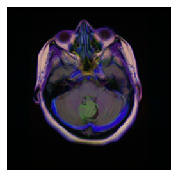

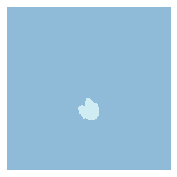

In [21]:
temp_img_file = small_data_path/'TCGA_HT_7680_19970202_6.tif'
temp_mask_file = get_y_fn(temp_img_file)
for f in [temp_img_file, temp_mask_file]:
    print('showing', f)
    if '_mask.tif' in f.name:
        mask = open_mask(f)
        print(mask.shape)
        mask.show()
    else:
        temp_img = open_image(f)
        print(temp_img.shape)
        temp_img.show()


#### Mask lable for segmentation 

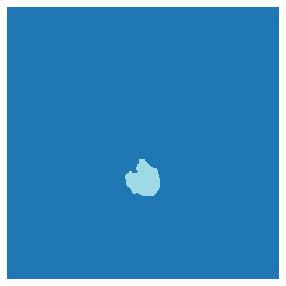

In [22]:
mask = open_mask(get_y_fn(temp_img_file), div=True)
mask.show(figsize=(5,5), alpha=1)

In [23]:
src_size = np.array(mask.shape[1:])
src_size, mask.data


(array([256, 256]),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

#### Spliting the folders for validatioin 

In [24]:
validation_folders = [
        'TCGA_HT_7694_19950404', 'TCGA_DU_5874_19950510', 'TCGA_DU_7013_19860523',
        'TCGA_HT_8113_19930809', 'TCGA_DU_6399_19830416', 'TCGA_HT_7684_19950816',
        'TCGA_CS_5395_19981004', 'TCGA_FG_6688_20020215', 'TCGA_DU_8165_19970205',
        'TCGA_DU_7019_19940908', 'TCGA_HT_7855_19951020', 'TCGA_DU_A5TT_19980318',
        'TCGA_DU_7300_19910814', 'TCGA_DU_5871_19941206', 'TCGA_DU_5855_19951217']


#### selecting batch size

In [76]:
codes = ['n', 'y']

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
bs=free//500
bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 0MB of GPU RAM free


### Loading data

In [77]:
class SegmentationLabelListWithDiv(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
class SegmentationItemListWithDiv(SegmentationItemList):
    _label_cls = SegmentationLabelListWithDiv


In [78]:
src = (SegmentationItemListWithDiv.from_folder(data_path, recurse=True)
       .filter_by_func(lambda x: not x.name.endswith('_mask.tif'))
       .split_by_valid_func(lambda x: x.parts[-2] in validation_folders)
       .label_from_func(get_y_fn, classes=codes))

In [79]:
# start by training on half size images
data = (src.transform(get_transforms(), size=src_size//2, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))


In [80]:
data.train_ds


LabelList (3415 items)
x: SegmentationItemListWithDiv
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelListWithDiv
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: /home/ec2-user/SageMaker/zh-nbs_2020-11-26/data

In [81]:
data.valid_ds


LabelList (512 items)
x: SegmentationItemListWithDiv
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelListWithDiv
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: /home/ec2-user/SageMaker/zh-nbs_2020-11-26/data

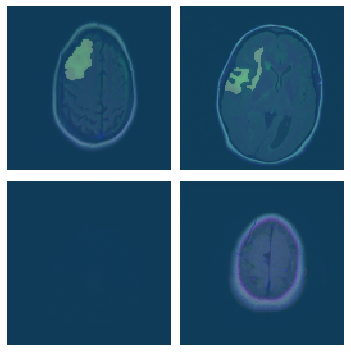

In [82]:
data.show_batch(4, figsize=(5,5))


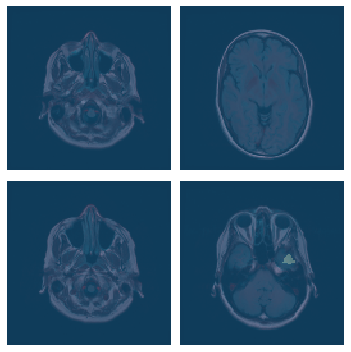

In [83]:
data.show_batch(4, figsize=(5,5), ds_type=DatasetType.Valid)

### Loading Model

In [84]:
wd=1e-2

In [85]:
learn = unet_learner(data, models.resnet18, wd=wd, metrics=dice, path='/home/ec2-user/SageMaker/zh-nbs_2020-11-26/')

#### Learning rate finder

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


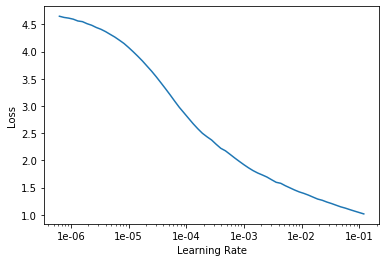

In [86]:
lr_find(learn)
learn.recorder.plot()

In [87]:
lr=1e-4

### Traning the model

In [88]:
learn.fit_one_cycle(4, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice,time
0,0.024652,0.019752,0.754528,54:08
1,0.014357,0.016495,0.799361,52:47
2,0.011672,0.012983,0.830930,50:29
3,0.008976,0.009966,0.868450,50:00


#### Traning and validation loss

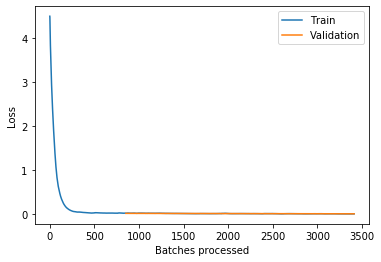

In [89]:
learn.recorder.plot_losses()

#### Dice coffecient w.r.t batch processed

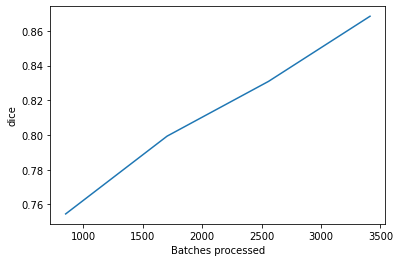

In [90]:
learn.recorder.plot_metrics()

#### Saving the model and showing results

In [91]:
def save_and_show(name):
    saved_to = learn.save(name, return_path=True)
    print('Saved to', saved_to, 'Note: this will be lost unless we commit the kernel')
    learn.load(name) # free memory etc
    learn.show_results(rows=4, figsize=(32, 32))

Saved to /home/ec2-user/SageMaker/zh-nbs_2020-11-26/models/saved.pth Note: this will be lost unless we commit the kernel


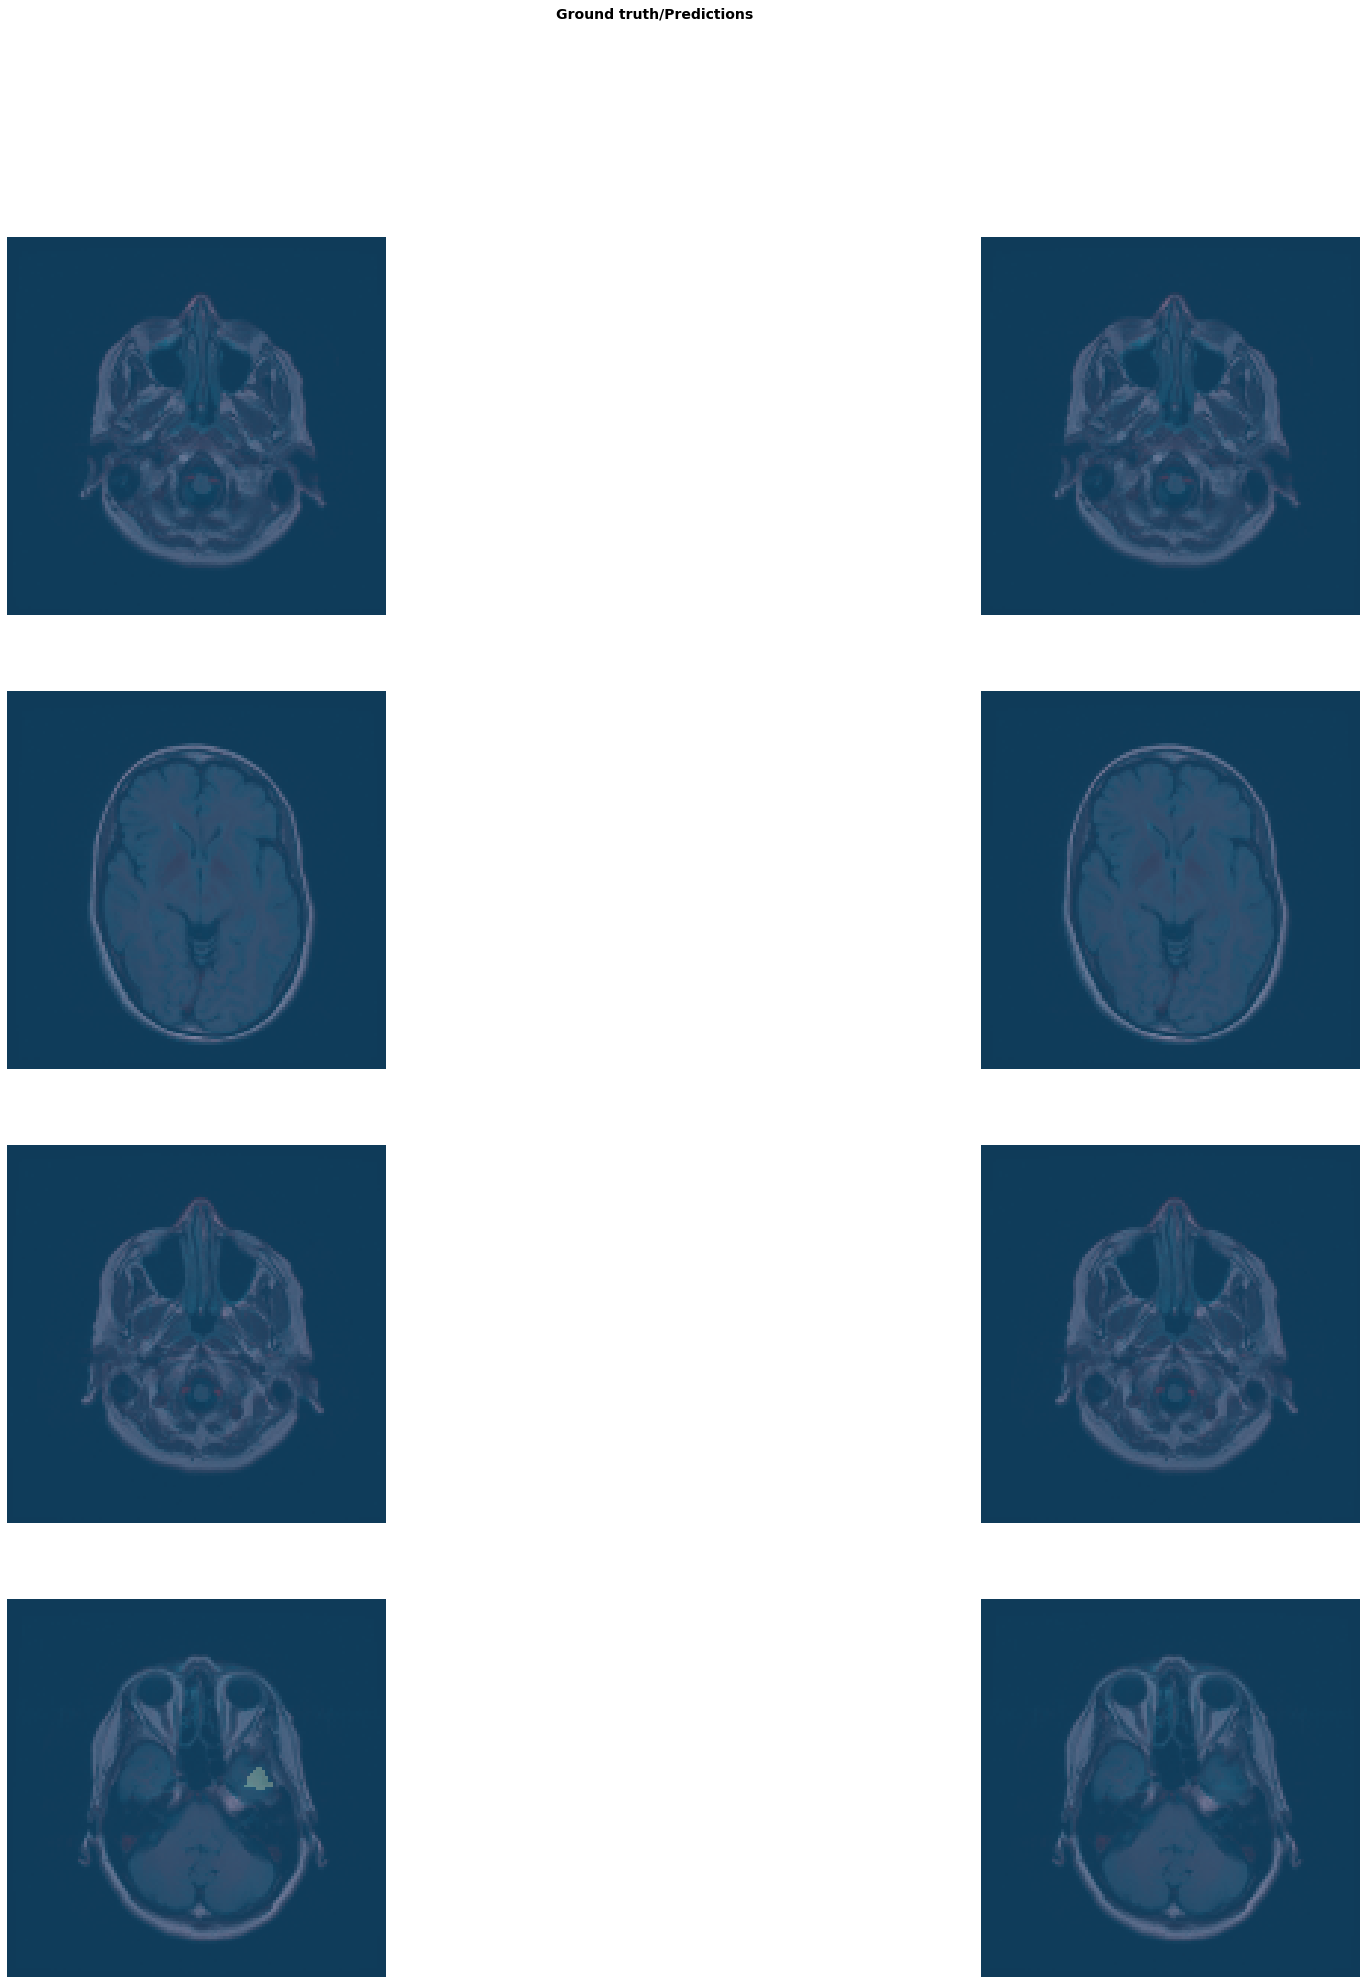

In [92]:
save_and_show('saved')
